# Properati - Modelling

**Content of this notebook:**
1. Correlations
2. Feature Selection
3. Modelling:
    - Linear Regression
    - Random Forest
    - XGBoost
    - CatBoost
4. Conclusion

*For the data preparation and exploration, please see the notebook called 'Properati - Data Preparation and Exploration'.*

Importing the libraries used in this notebook

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
from sklearn import preprocessing
from sklearn.feature_selection import RFECV
from sklearn import linear_model
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RandomizedSearchCV
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from catboost import CatBoostRegressor
import shap  
shap.initjs()
import pickle

Unpickle the dateframe prepared in the previous notebook.

In [2]:
with open('properati_clean.pkl', 'rb') as f_df:
    properati = pickle.load(f_df)

In [3]:
properati.columns

Index(['id', 'start_date', 'end_date', 'created_on', 'lat', 'lon',
       'neighbourhood', 'rooms', 'bedrooms', 'bathrooms', 'surface_total',
       'surface_covered', 'price', 'currency', 'title', 'description',
       'property_type', 'created_on_year', 'created_on_month', 'Year',
       'Month_name', 'Month_number', 'Exchange_rate', 'price_usd',
       'price_m2_covered', 'property_type_general', 'surface_category',
       'rooms_average', 'bathrooms_average', 'geometry', 'BARRIO', 'pool',
       'parking', 'elevator', 'gym', 'balcony/patio', 'garden', 'terrace',
       'bbq', 'sum', 'min_dist_to_subte', 'min_dist_to_subteD', 'ALMAGRO',
       'BALVANERA', 'BARRACAS', 'BELGRANO', 'BOCA', 'BOEDO', 'CABALLITO',
       'CHACARITA', 'COGHLAN', 'COLEGIALES', 'CONSTITUCION', 'FLORES',
       'FLORESTA', 'LINIERS', 'MATADEROS', 'MONSERRAT', 'MONTE CASTRO',
       'NUEVA POMPEYA', 'NUÑEZ', 'PALERMO', 'PARQUE AVELLANEDA',
       'PARQUE CHACABUCO', 'PARQUE CHAS', 'PARQUE PATRICIOS', 'PATERNA

I will drop a few columns that were created as helper columns in the previous note and/or that I won't be using for my models.

In [4]:
properati = properati.drop(columns=['start_date', 'end_date', 'created_on', 'created_on_year', 'created_on_month',
                                   'Year', 'Month_name', 'Month_number', 'Exchange_rate', 'rooms_average', 
                                    'bathrooms_average', 'geometry'])

## 1. Correlations

Checking out the correlations between the dependent variable (total property price in usd) and the independent variables. Out of curiousity I will also plot the correlations between the price per m2 and the independent variables. I have too many variables to plot the correlations between all variables. I am not too worried about multicollinearity though, as for most of the models I will apply (with exception of the linear regression) multicollinearity isn't an issue.

<AxesSubplot:>

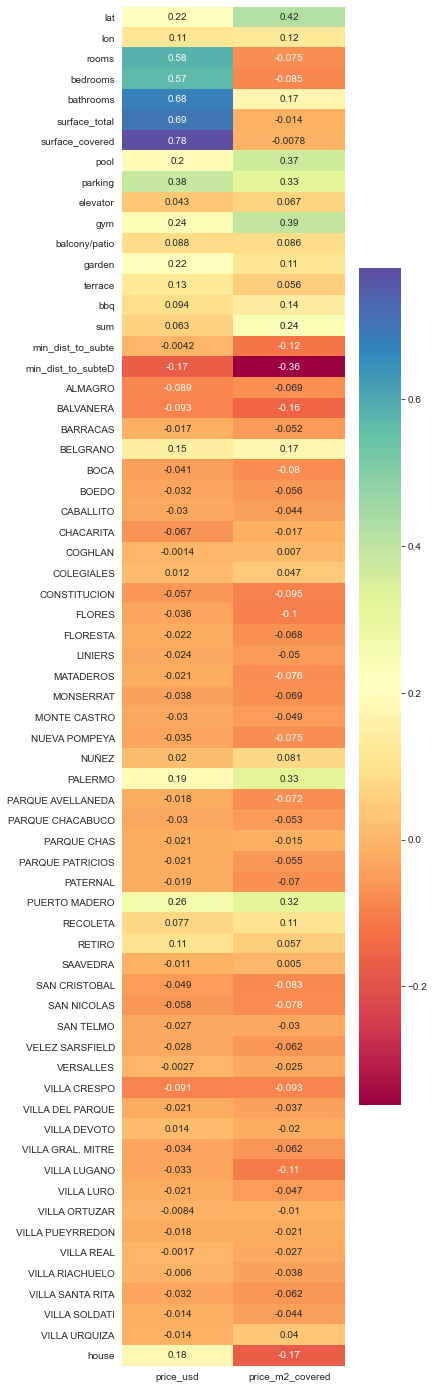

In [5]:
palette=sns.color_palette("Spectral", n_colors=256)

plt.figure(figsize=(5,25))
sns.heatmap(properati.corr().loc[~properati.corr().columns.isin(['price', 'price_usd', 'price_m2_covered']),
                                 ['price_usd', 'price_m2_covered']], square=False, annot=True, cmap=palette)

Variables that correlate most with the **total property price** (correlation >= 0.15):
- surface covered (0.78)
- surface total (0.69)
- bathrooms (0.68)
- rooms (0.58)
- bedrooms (0.57)
- parking (0.38)
- puerto madero (0.26)
- gym (0.24)
- garden (0.22)
- lat (0.22)
- pool (0.2)
- house (0.18)
- palermo (0.19)
- min distance to subte D (-0.17)
- belgrano (0.15)

Variables that correlate most with the **m2 price** (correlation >= 0.15):
- lat (0.42)
- gym (0.39)
- pool (0.37)
- min distance to subte D (-0.36)
- parking (0.33)
- palermo (0.33)
- puerto madero (0.32)
- sum (0.24)
- house (-0.17)
- bathrooms (0.17)
- belgrano (0.17)
- balvanera (-0.16)

## 2. Feature selection

The price distribution is skewed to the right. A log transformation makes this variable closer to a normal distribution. Therefore I will use the log of 'price_usd' as the dependent variable in the models below.

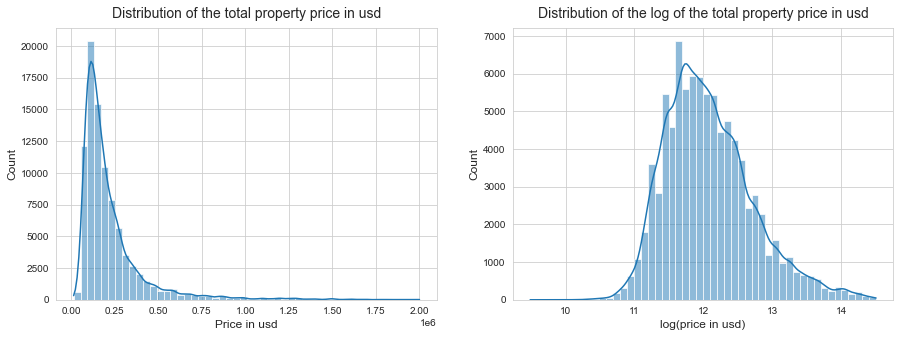

In [6]:
f, axes = plt.subplots(2, 1, figsize=(15,5))

ax1 = plt.subplot(121)
sns.histplot(properati.price_usd, kde=True, bins=50, ax=ax1)
plt.title('Distribution of the total property price in usd', fontsize=14, pad=10)
plt.xlabel('Price in usd', fontsize=12)
plt.ylabel('Count', fontsize=12)

ax2 = plt.subplot(122)
sns.histplot(np.log(properati.price_usd), kde=True, ax=ax2, bins=50)
plt.title('Distribution of the log of the total property price in usd', fontsize=14, pad=10)
plt.xlabel('log(price in usd)', fontsize=12)
plt.ylabel('Count', fontsize=12)

plt.show()

I start by assigning all my independent variables to 'X' and the loc of 'price_usd' to 'y'.

In [7]:
X = properati[['lat', 'lon', 'rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered', 'pool',
               'parking', 'elevator', 'gym', 'balcony/patio', 'garden', 'terrace', 'bbq', 'sum', 'min_dist_to_subte',
               'min_dist_to_subteD', 'ALMAGRO', 'BALVANERA', 'BARRACAS', 'BELGRANO', 'BOCA', 'BOEDO', 
               'CABALLITO', 'CHACARITA', 'COGHLAN', 'COLEGIALES', 'CONSTITUCION', 'FLORES', 'FLORESTA', 
               'LINIERS', 'MATADEROS', 'MONSERRAT', 'MONTE CASTRO', 'NUEVA POMPEYA', 'NUÑEZ', 'PALERMO',
               'PARQUE AVELLANEDA', 'PARQUE CHACABUCO', 'PARQUE CHAS', 'PARQUE PATRICIOS', 'PATERNAL', 
               'PUERTO MADERO', 'RECOLETA', 'RETIRO', 'SAAVEDRA', 'SAN CRISTOBAL', 'SAN NICOLAS', 
               'SAN TELMO', 'VELEZ SARSFIELD', 'VERSALLES', 'VILLA CRESPO', 'VILLA DEL PARQUE', 'VILLA DEVOTO', 
               'VILLA GRAL. MITRE', 'VILLA LUGANO', 'VILLA LURO', 'VILLA ORTUZAR', 'VILLA PUEYRREDON', 
               'VILLA SANTA RITA', 'VILLA URQUIZA', 'house']]

y = np.log(properati['price_usd'])

I will split the dataset into a train set (80% of the data) and test set (20% of the date).

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=12)

I will set KFold at 5 splits with shuffle for all cross validations I will use.

In [9]:
kf = KFold(n_splits=5, shuffle=True, random_state=0)

I will use recursive feature elimination to select my final features. I decided to use a model based on decision trees for the feature selection, because during some first try outs I noticed that this type of model works much better on my dataset than linear regressions, so I prefer to optimize the features for this type of model.

I have commented out the section below, because it takes a long time to run, but I am using the features selected by RFECV.

In [10]:
#estimator = XGBRegressor()
#selector = RFECV(estimator, step=1, cv=kf, scoring='neg_mean_squared_error')
#selector.fit(X_train, y_train)

In [11]:
#X.loc[:,selector.support_].columns

In [12]:
features_to_keep = ['lat', 'lon', 'rooms', 'bedrooms', 'bathrooms', 'surface_total',
                    'surface_covered', 'pool', 'parking', 'gym', 'balcony/patio', 'garden',
                    'terrace', 'bbq', 'sum', 'min_dist_to_subte', 'min_dist_to_subteD',
                    'ALMAGRO', 'BALVANERA', 'BELGRANO', 'BOCA', 'CABALLITO', 'CHACARITA',
                    'COGHLAN', 'CONSTITUCION', 'MONSERRAT', 'NUEVA POMPEYA', 'PALERMO',
                    'PARQUE CHACABUCO', 'PATERNAL', 'PUERTO MADERO', 'RECOLETA', 'RETIRO',
                    'SAAVEDRA', 'SAN CRISTOBAL', 'SAN NICOLAS', 'VILLA DEVOTO',
                    'VILLA LUGANO']

X_train = X_train[features_to_keep]
X_test = X_test[features_to_keep]

In [13]:
X_train.shape

(71712, 38)

In [14]:
y_train.shape

(71712,)

One of the models I will use is sensitive to the scale of the data, therefore I will normalize X_train and X_test.

In [15]:
stdscaler = preprocessing.StandardScaler()

X_train_norm = pd.DataFrame(stdscaler.fit_transform(X_train), columns=X_train.columns)
X_test_norm = pd.DataFrame(stdscaler.transform(X_test), columns=X_test.columns)

I will create a funtion that will plot the predictions for the train and test set against their real values.

In [16]:
 def plot_predictions(y_pred_train, y_train, y_pred_test, y_test):
    
    fig = plt.figure(figsize=(15,5))
    
    plt.subplot(1,2,1)
    plt.scatter(y_pred_train, y_train, s=10, c='b', alpha=0.3, zorder=10)
    plt.plot(y_train, y_train, c='grey')
    plt.xlabel('Predictions model', fontsize=12)
    plt.ylabel('Real values', fontsize=12)
    plt.title('Training predictions vs. Real values', fontsize=14, pad=10)

    plt.subplot(1,2,2)
    plt.plot(y_test, y_test, c='grey')
    plt.scatter(y_pred_test, y_test, s=10, c='g', alpha=0.3, zorder=10)
    plt.xlabel('Predictions model', fontsize=12)
    plt.ylabel('Real values', fontsize=12)
    plt.title('Test predictions vs. Real values', fontsize=14, pad=10)
    
    plt.show()

## 3. Modelling

### 3.1 Linear Regression

First, I will apply a simple Linear Regression model. Since a linear regression is sensitive to the scale of the input variables, I will train this model on the normalized data.

In [17]:
lm = linear_model.LinearRegression()
lm.fit(X_train_norm, y_train)
y_pred_train = lm.predict(X_train_norm)
y_pred_test = lm.predict(X_test_norm)

The graphs below show the prediction for the train and test set against their real values. In general the model seems to be doing a decent job at predicting the property prices. Only where log(price_usd) is smaller than 11, it seems to systematically predict prices that are higher. And there are a few very high predictions that in reality should be lower.

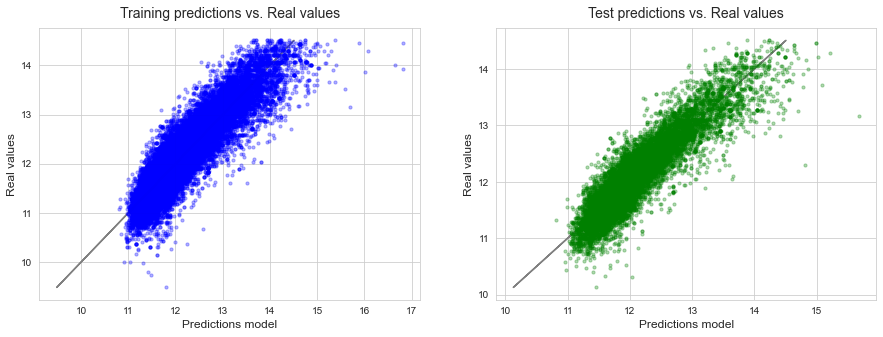

In [18]:
plot_predictions(y_pred_train, y_train, y_pred_test, y_test)

I will create a dataframe to store the results of the metrics MSE and R2 for both the train and test set. This will help me to compare the performance of the different models.

In [19]:
results = pd.DataFrame(columns=['model', 'MSE Train', 'MSE Test', 'R2 Train', 'R2 Test'])

results.loc[0, 'model'] = 'Linear Regresssion'
results.loc[0, 'MSE Train'] = mean_squared_error(y_train, y_pred_train).round(3)
results.loc[0, 'MSE Test'] = mean_squared_error(y_test, y_pred_test).round(3)
results.loc[0, 'R2 Train'] = r2_score(y_train, y_pred_train).round(3)
results.loc[0, 'R2 Test'] = r2_score(y_test, y_pred_test).round(3)

In [20]:
results

,model,MSE Train,MSE Test,R2 Train,R2 Test
0,Linear Regresssion,0.073,0.073,0.823,0.82


The beta coefficients of the different features can tell us something about the importance these features have in the model. Below I have listed the features in descending order of their absolute beta coefficients. The most important features seem to be the ***latitude*** (positive effect: the bigger the latitude, the higher the predicted price), the amount of ***rooms*** (positive effect: the more rooms, the higher the predicted price), the ***covered surface*** (positive effect: the bigger the covered surface, the higher the predicted price),  the ***minimum distance to subte*** (positive effect: the bigger the distance to nearest metro station, the higher the predicted price), and the ***longitude*** (positive effect: the bigger the longitude, the higher the predicted price).

I am surprised to see that the model predicts higher prices with bigger distances to the nearest metro station. I expected to see the opposite, that properties that are well conected to the metro would have higher prices.

In [21]:
sorted(list(zip(X.columns, lm.coef_.round(5))), key=lambda x: abs(x[1]), reverse=True)

[('lat', 0.23322),
 ('rooms', 0.21107),
 ('surface_covered', 0.2025),
 ('min_dist_to_subte', 0.14028),
 ('lon', 0.13911),
 ('bathrooms', 0.0822),
 ('parking', 0.07328),
 ('FLORESTA', 0.07298),
 ('COLEGIALES', 0.07131),
 ('surface_total', 0.05018),
 ('elevator', 0.04377),
 ('LINIERS', 0.04259),
 ('bedrooms', -0.03276),
 ('gym', 0.02964),
 ('BELGRANO', 0.02866),
 ('CABALLITO', -0.02764),
 ('ALMAGRO', -0.02751),
 ('BARRACAS', -0.02719),
 ('pool', 0.02657),
 ('MONSERRAT', -0.02553),
 ('NUEVA POMPEYA', -0.02391),
 ('PALERMO', -0.0194),
 ('MONTE CASTRO', -0.01798),
 ('min_dist_to_subteD', 0.01769),
 ('BOCA', -0.01626),
 ('CONSTITUCION', 0.01518),
 ('FLORES', -0.01512),
 ('garden', 0.01485),
 ('BALVANERA', 0.01479),
 ('CHACARITA', -0.01462),
 ('MATADEROS', 0.0117),
 ('NUÑEZ', 0.01139),
 ('COGHLAN', -0.01075),
 ('terrace', 0.00803),
 ('sum', 0.00703),
 ('BOEDO', -0.00658),
 ('balcony/patio', 0.0018),
 ('bbq', -0.00032)]

### 3.2 Random Forest Regressor

Second, I will apply a Random Forest Regressor. I have optimized the hyperparameters with a randomized search. Below the randomized search part is commented out, because it is computationally heavy.

In [22]:
#rfc =  RandomForestRegressor(random_state=12)

#n_estimators = [100, 500]
#depth = [10, 15, 30]
#max_features = ['auto', 0.7, 0.5, 0.3]
#min_samples_leaf = [3, 5, 7, 10]

#param_grid = dict(n_estimators=n_estimators, max_depth=depth, max_features=max_features, min_samples_leaf=min_samples_leaf)

In [23]:
#model_RF = RandomizedSearchCV(rfc, param_grid, n_iter=20, cv=kf, verbose=0, random_state=12, n_jobs=-1)
#model_RF.fit(X_train, y_train)

In [24]:
#model_RF.best_estimator_

In [25]:
#model_RF.best_score_

In [26]:
model_RF = RandomForestRegressor(random_state=12, max_depth=30, min_samples_leaf=3)
model_RF.fit(X_train, y_train)
y_pred_train = model_RF.predict(X_train)
y_pred_test = model_RF.predict(X_test)

The predictions of the Random Forest Regressor are even better than the predictions of the Linear Regression. It especially seems to do a much better job at predicting the lowest and highest values.

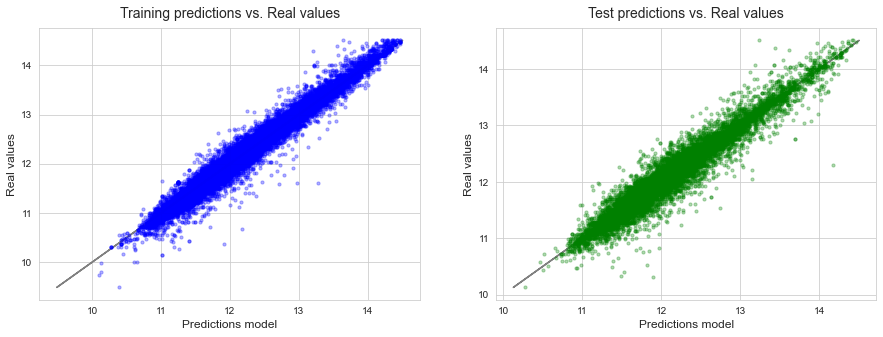

In [27]:
plot_predictions(y_pred_train, y_train, y_pred_test, y_test)

Although it seems to overfit a little bit on the train set, the Random Forest Regressor has significantly better MSE and R2 scores than the Linear Regression.

In [28]:
results.loc[1, 'model'] = 'Random Forest'
results.loc[1, 'MSE Train'] = mean_squared_error(y_train, y_pred_train).round(3)
results.loc[1, 'MSE Test'] = mean_squared_error(y_test, y_pred_test).round(3)
results.loc[1, 'R2 Train'] = r2_score(y_train, y_pred_train).round(3)
results.loc[1, 'R2 Test'] = r2_score(y_test, y_pred_test).round(3)

In [29]:
results

,model,MSE Train,MSE Test,R2 Train,R2 Test
0,Linear Regresssion,0.073,0.073,0.823,0.82
1,Random Forest,0.008,0.022,0.98,0.946


To get a better understanding of the importance of the different features in the Random Forest model, I will use the Tree Explainer of the Shap library. Because of computational limitations (applying this function on a Random Forest is computational very heavy), I am applying the Tree Explainer to a sample of 1000 rows of the test set, instead of the entire test set.

By far the most important features in the Random Forest Regressor seem to be the **covered surface** (positive effect: the bigger the covered surface, the higher the price). After follow the **total surface** (positive effect: the bigger the total surface, the higher the price), and the **latitude** (positive effect: the bigger the latitude, the higer the price).

In [30]:
background = X_test.sample(1000)
explainer = shap.TreeExplainer(model_RF, background)

In [31]:
shap_values = explainer.shap_values(background)

 99%|===================| 993/1000 [01:44<00:00]        

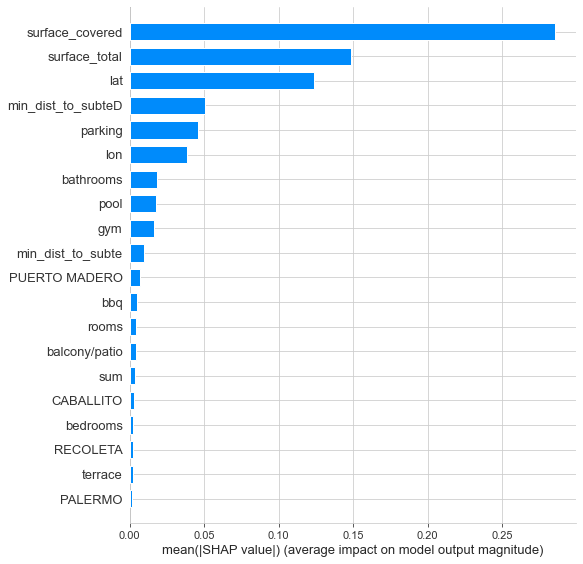

In [32]:
shap.summary_plot(shap_values, background, plot_type="bar")

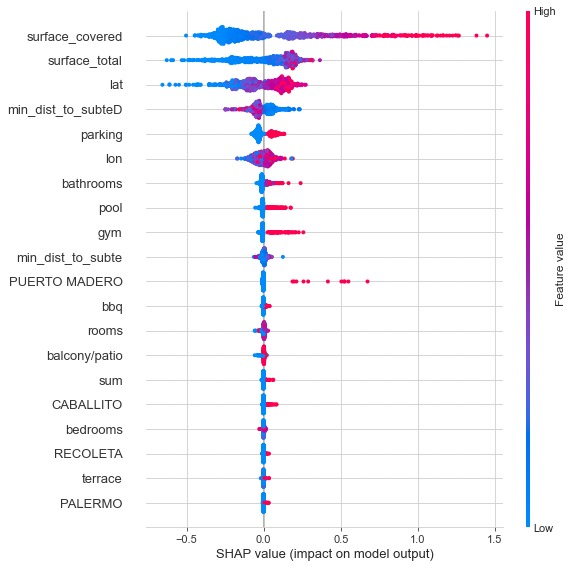

In [33]:
shap.summary_plot(shap_values, background)

### 3.3 XGBoost Regressor

Third, I will apply the XGBoost Regressor. I have optimized the hyperparameters with a randomized search. Below the randomized search part is commented out, because it is computationally heavy.

In [34]:
#xgb =  XGBRegressor()

#learning_rate = [0.05, 0.1, 0.3]
#n_estimators = [100, 100]
#max_depth = [5, 10, 15, 30]

#param_grid = dict(learning_rate=learning_rate, n_estimators=n_estimators, max_depth=max_depth)

In [35]:
#model_XGB = RandomizedSearchCV(xgb, param_grid, n_iter=10, cv=kf, verbose=0, random_state=12, n_jobs=-1)
#model_XGB.fit(X_train, y_train)

In [36]:
#model_XGB.best_estimator_

In [37]:
#model_XGB.best_score_

The randomized search recommended a *max_depth* de 30. However, a max_depth of 30 hace makes the model very heavy and I cannot analyse it with the SHAP library after, nor upload the trained model to Github (from where I will deploy the model). A *max_depth* of 18 gives me similar results and it does allow me to analyse the importance of the features with SHAP and to upload the trained model to Github. Therefore, I choose to continue with a  *max_depth* of 18.

In [38]:
model_XGB = XGBRegressor(random_state=12, max_depth=18)
model_XGB.fit(X_train, y_train)
y_pred_train = model_XGB.predict(X_train)
y_pred_test = model_XGB.predict(X_test)

[12:27:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


The model seems to predict the training set almost perfectly. As expected, there is some more error in the predictions on the test set, but it still does a really good job.

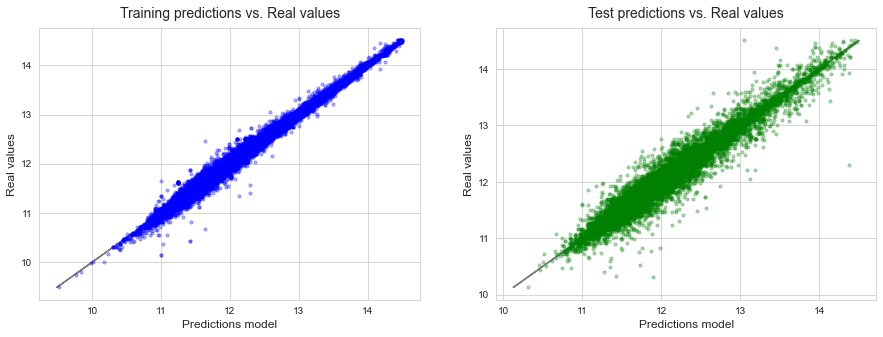

In [39]:
plot_predictions(y_pred_train, y_train, y_pred_test, y_test)

The MSE and R2 of the XGBoost Regressor on the test set are even better than the Random Forest Regressor. Just like the Random Forest Regressor, the XGBoost Regressor seem to overfit a bit on the train set. 

In [40]:
results.loc[2, 'model'] = 'XGBoost'
results.loc[2, 'MSE Train'] = mean_squared_error(y_train, y_pred_train).round(3)
results.loc[2, 'MSE Test'] = mean_squared_error(y_test, y_pred_test).round(3)
results.loc[2, 'R2 Train'] = r2_score(y_train, y_pred_train).round(3)
results.loc[2, 'R2 Test'] = r2_score(y_test, y_pred_test).round(3)

In [41]:
results

,model,MSE Train,MSE Test,R2 Train,R2 Test
0,Linear Regresssion,0.073,0.073,0.823,0.82
1,Random Forest,0.008,0.022,0.98,0.946
2,XGBoost,0.003,0.019,0.993,0.953


The most important features in the XGBoost Regressor are also the **covered surface** (positive effect: the bigger the covered surface, the higher the price), the **total surface** (positive effect: the bigger the total surface, the higher the price), and the **latitude** (positive effect: the bigger the latitude, the higer the price).

In [42]:
explainer = shap.TreeExplainer(model_XGB, background)

In [43]:
shap_values = explainer.shap_values(background)

 99%|===================| 993/1000 [00:51<00:00]        

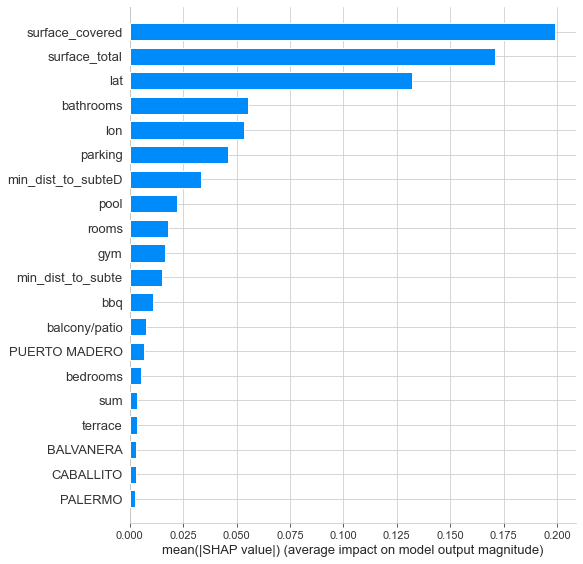

In [44]:
shap.summary_plot(shap_values, background, plot_type="bar")

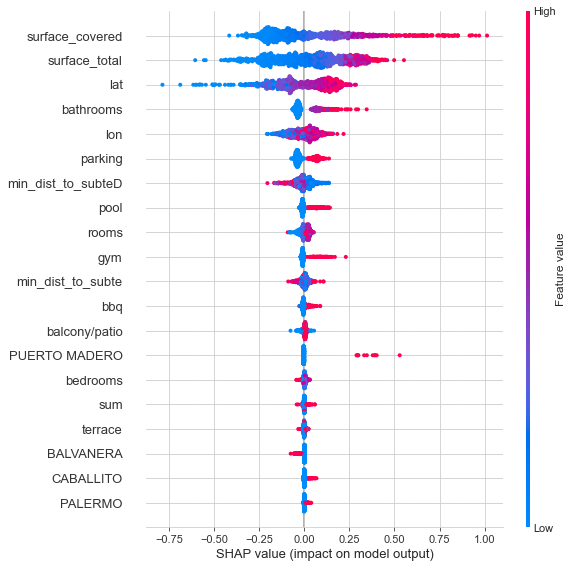

In [45]:
shap.summary_plot(shap_values, background)

### 3.4 CatBoost Regresssor

Finally, I will apply the CatBoost Regressor. I have optimized the hyperparameters with a randomized search. Below the randomized search part is commented out, because it is computationally heavy.

In [46]:
#model_catboost = CatBoostRegressor(random_state=2)

#grid = {'learning_rate': [0.03, 0.1],
#        'depth': [4, 6, 10],
#        'l2_leaf_reg': [1, 3, 5, 7, 9]}

#model_catboost.randomized_search(grid, X=X_train, y=y_train, cv=kf, n_iter=10, plot=True)

In [47]:
model_catboost = CatBoostRegressor(random_state=12, depth=10, l2_leaf_reg=3, learning_rate=0.1)
model_catboost.fit(X_train, y_train, verbose=False)
y_pred_train = model_catboost.predict(X_train)
y_pred_test = model_catboost.predict(X_test)

The results of the Catboost Regressor look similar to those of the Random Forest Regressor.

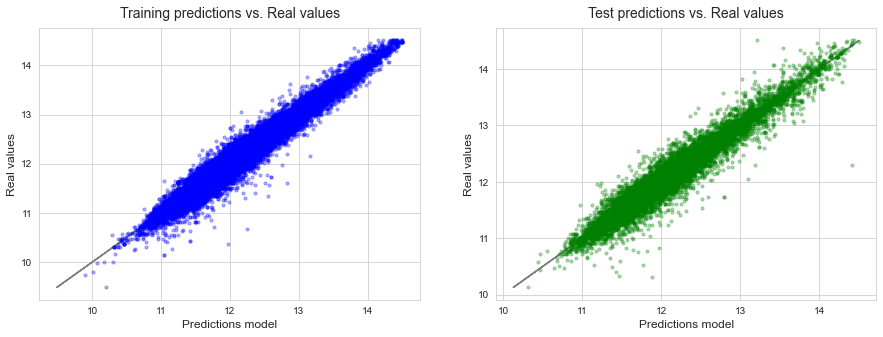

In [48]:
plot_predictions(y_pred_train, y_train, y_pred_test, y_test)

The MSE and R2 scores of the Catboost Regressor are also very similar to the Random Forest Regressor.

In [49]:
results.loc[3, 'model'] = 'CatBoost'
results.loc[3, 'MSE Train'] = mean_squared_error(y_train, y_pred_train).round(3)
results.loc[3, 'MSE Test'] = mean_squared_error(y_test, y_pred_test).round(3)
results.loc[3, 'R2 Train'] = r2_score(y_train, y_pred_train).round(3)
results.loc[3, 'R2 Test'] = r2_score(y_test, y_pred_test).round(3)

In [50]:
results

,model,MSE Train,MSE Test,R2 Train,R2 Test
0,Linear Regresssion,0.073,0.073,0.823,0.82
1,Random Forest,0.008,0.022,0.98,0.946
2,XGBoost,0.003,0.019,0.993,0.953
3,CatBoost,0.013,0.022,0.969,0.946


The most important features in the Catboost Regressor is the the **total surface** (positive effect: the bigger the total surface, the higher the price). After follow the **covered surface** (positive effect: the bigger the covered surface, the higher the price), and the **latitude** (positive effect: the bigger the latitude, the higer the price).

In [51]:
explainer = shap.TreeExplainer(model_catboost)
shap_values = explainer.shap_values(X_test)

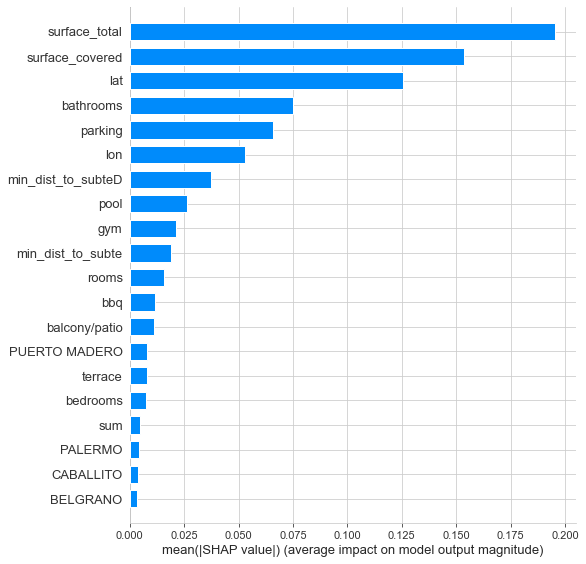

In [52]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

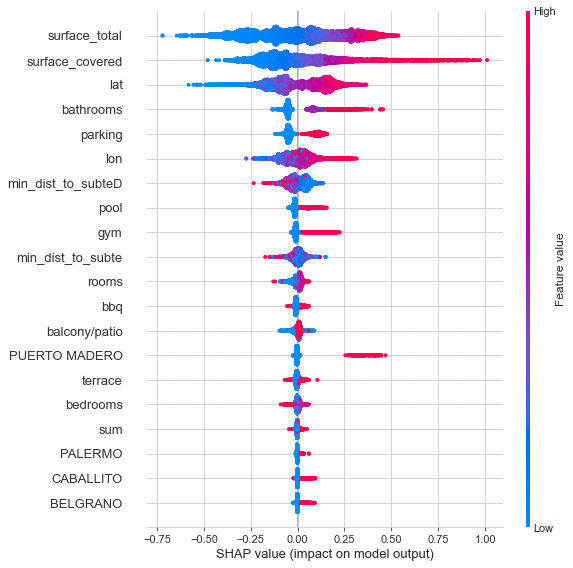

In [53]:
shap.summary_plot(shap_values, X_test)

## 4. Conclusion

The XGBoost Regressor has the best results on the test set: a mean squared error of 0.019 and an r-squared of 0.953. Therefore I have decided to use this model in my final application.

In [54]:
results

,model,MSE Train,MSE Test,R2 Train,R2 Test
0,Linear Regresssion,0.073,0.073,0.823,0.82
1,Random Forest,0.008,0.022,0.98,0.946
2,XGBoost,0.003,0.019,0.993,0.953
3,CatBoost,0.013,0.022,0.969,0.946


The most important features in the XGBoost Regressor:
- **Covered surface** (positive effect): the bigger the covered surface, the higher the price
- **Total surface** (positive effect): the bigger the total surface, the higher the price
- **Latitude** (positive effect): the bigger the latitude (the more north), the higer the price

Saving the final model as a pickle.

In [55]:
with open('properati_model_XGB.pkl', 'wb') as f_model:
    pickle.dump(model_XGB, f_model)